# **This model uses US cars dataset to predict car prices with more than 73% accuracy**

First, we import all the required libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, RidgeCV
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.feature_selection import chi2
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures


from sklearn.feature_selection import RFE

Next, we define functions to understand US Cars dataset, and deal with outliers (using IQR)

In [2]:
def understand_variables(dataset):
    print(type(dataset))
    print(dataset.shape)
    print(dataset.head())
    print(dataset.columns)
    print(dataset.nunique(axis=0))
    print(dataset.describe())
    print(dataset.describe(exclude=[np.number]))
    print("\nNull count :\n"+str(dataset.isnull().sum()))
    
    
def EDA(dataset,feature_type):
    
    if feature_type == "Categorical":
        
        categorical_features=[feature for feature in dataset.columns if dataset[feature].dtype=='O']   
        dataframes=[]
        for feature in categorical_features:
            dataframe=dataset[feature].value_counts().rename_axis(feature).reset_index(name='counts')
            dataframes.append(dataframe)

        for i in range(len(dataframes)):
            print(dataframes[i],'\n')
            
    elif feature_type == "Numeric":
        
        numerical_features=[feature for feature in dataset.columns if dataset[feature].dtype!='O']
        
        for feature in numerical_features:
            sns.distplot(dataset[feature])
            plt.show()


        sns.pairplot(dataset,kind="reg")
        plt.show()


def outlier_processing(dataset):
    # Using IQR

    Q1 = dataset.quantile(0.25)
    Q3 = dataset.quantile(0.75)
    IQR = Q3 - Q1
    
    #outlier_col = ['year']
    
    print("\n-------------\n% of outliers\n")    
    print(((dataset < (Q1 - 1.5 * IQR)) |(dataset > (Q3 + 1.5 * IQR))).sum()/len(dataset)*100)
    
    for col in list(IQR.index): 
        
        if col!='price':
        
            dataset.loc[dataset[col] < (Q1 - 1.5 * IQR)[col],[col]] = (Q1 - 1.5 * IQR)[col]
            dataset.loc[dataset[col] > (Q3 + 1.5 * IQR)[col],[col]] = (Q3 + 1.5 * IQR)[col]
            
            dataset[col] = dataset[col].round(0).astype(int)
    
    
    for col in ['price']:
        dataset = dataset[(dataset[col] <= (Q3 + 1.5 * IQR)[col]) & (dataset[col] >= (Q1 - 1.5 * IQR)[col])]
        #dataset[col] = dataset[col].round(0).astype(int)
        
    ## We eliminate rows with price as outliers, rest we replace with upper/lower boundary

    return dataset

Now, we import the USA Cars dataset, and use our defined function to understand this dataset. We drop columns "lot" and "vin" since these are IDs that are cannot be used to train our model.

In [4]:
#### sitio originaal del dataset
####cars_dataset = pd.read_csv("../input/usa-cers-dataset/USA_cars_datasets.csv",index_col="Unnamed: 0")
### Sitio para preprocesar
cars_dataset = pd.read_csv("USA_cars_datasets.csv",index_col="Unnamed: 0")
cars_dataset = cars_dataset.drop(["lot","vin"],axis=1)
understand_variables(cars_dataset)

<class 'pandas.core.frame.DataFrame'>
(2499, 10)
   price      brand    model  year  ...   color       state country      condition
0   6300     toyota  cruiser  2008  ...   black  new jersey     usa   10 days left
1   2899       ford       se  2011  ...  silver   tennessee     usa    6 days left
2   5350      dodge      mpv  2018  ...  silver     georgia     usa    2 days left
3  25000       ford     door  2014  ...    blue    virginia     usa  22 hours left
4  27700  chevrolet     1500  2018  ...     red     florida     usa  22 hours left

[5 rows x 10 columns]
Index(['price', 'brand', 'model', 'year', 'title_status', 'mileage', 'color',
       'state', 'country', 'condition'],
      dtype='object')
price            790
brand             28
model            127
year              30
title_status       2
mileage         2439
color             49
state             44
country            2
condition         47
dtype: int64
          price     year     mileage
count  2499.000 2499.000    2

Now, we perfrom EDA on each column, first on categorical, followed by numerical

In [5]:
EDA(cars_dataset,feature_type="Categorical")

              brand  counts
0              ford    1235
1             dodge     432
2            nissan     312
3         chevrolet     297
4               gmc      42
5              jeep      30
6          chrysler      18
7               bmw      17
8           hyundai      15
9               kia      13
10            buick      13
11         infiniti      12
12            honda      12
13         cadillac      10
14    mercedes-benz      10
15        heartland       5
16             land       4
17             audi       4
18        peterbilt       4
19            acura       3
20          lincoln       2
21            mazda       2
22            lexus       2
23           jaguar       1
24         maserati       1
25           toyota       1
26              ram       1
27  harley-davidson       1 

       model  counts
0       door     651
1      f-150     219
2      doors     148
3    caravan     102
4        mpv      87
..       ...     ...
122  connect       1
123     juke      

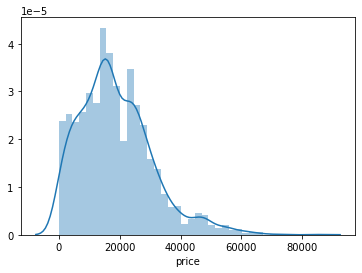

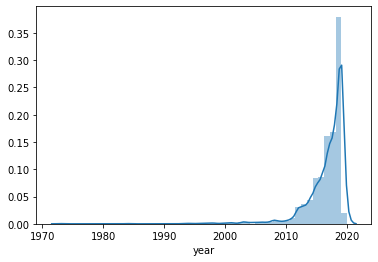

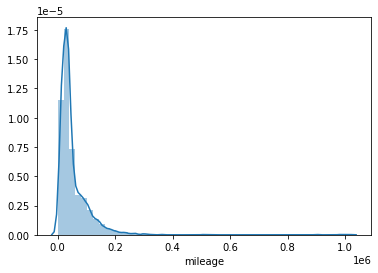

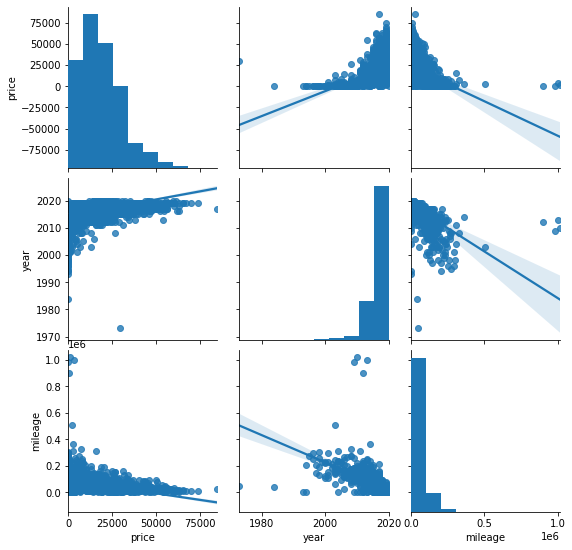

In [6]:
EDA(cars_dataset,feature_type="Numeric")

Next, we perform some Feature Engineering, deal with outliers (using defined function) and convert categorical variables into numerical dummy variables,
Since we can only use numerical variables in linear regression (E.g. country column will be split into 2 columns, say *is_country_USA* and *is_country_Canada*. If country column had value as USA before conversion, *is_country_USA* = 1 and *is_country_Canada* = 0 after conversion)

In [7]:
################ feature engineering ###########

######### convert year to age (2020 - year)
cars_dataset.year = 2021 - cars_dataset.year

######## condition column : [Listings expired = 0, remove 'left' from others, convert everything to minutess ]

cars_dataset.loc[cars_dataset.condition == "Listing Expired", 'condition'] = "0 minutes left"
cars_dataset['condition'] = cars_dataset.condition.str.replace("left","")
cars_dataset.loc[cars_dataset.condition.str.contains("minutes"),'condition'] = (cars_dataset.loc[cars_dataset.condition.str.contains("minutes"),'condition'].astype(str).str.split().str[0].astype(int)).astype(str)
cars_dataset.loc[cars_dataset.condition.str.contains("hours"),'condition'] = (cars_dataset.loc[cars_dataset.condition.str.contains("hours"),'condition'].astype(str).str.split().str[0].astype(int) * 60).astype(str)
cars_dataset.loc[cars_dataset.condition.str.contains("days"),'condition'] = (cars_dataset.loc[cars_dataset.condition.str.contains("days"),'condition'].astype(str).str.split().str[0].astype(int) * 60*24).astype(str)
cars_dataset.condition = cars_dataset.condition.astype(int)

######## dealing with outliers ########

cars_dataset = outlier_processing(cars_dataset)

#cars_dataset = cars_dataset[cars_dataset.price>0]


############## Correlation check ############

corr = cars_dataset.corr()
#sns.heatmap(corr, annot=True)


####### get dummies ########

cars_dataset = pd.get_dummies(cars_dataset, dummy_na=True)



-------------
% of outliers

brand           0.000
color           0.000
condition      13.405
country         0.000
mileage         7.563
model           0.000
price           2.561
state           0.000
title_status    0.000
year            5.042
dtype: float64


Feauture Selection using 
* correlation : removes one of the columns in a pair of highly correlated columns
* p-value : measure of statistical significance. Here, null hypothesis is that *an independent variable has no correlation with dependent variable*, Price. Any independent variable with p-value <= 0.05 (alpha), is retained (thus rejecting the null hypothesis), and rest are eliminated

In [8]:
############## Feauture Selection (using Correlation) ######

corr = cars_dataset.corr()

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = cars_dataset.columns[columns]
cars_dataset = cars_dataset[selected_columns]


############## Feauture Selection (using p-value) ######

X = cars_dataset.drop("price",axis=1)
y = cars_dataset["price"]


X = sm.add_constant(X)
mod = sm.OLS(y,X)
fii = mod.fit()
sm_p_value = fii.summary2().tables[1]['P>|t|']
pvalues = pd.Series(sm_p_value)


sig_p_val = pvalues[pvalues<=0.05]
sig_p_val.drop("const", inplace=True)
cars_col_index = sig_p_val.index

cars_col_index = pd.Series(cars_col_index)

cars_col_index = list(cars_col_index)

cars_dataset = cars_dataset[cars_col_index] 
cars_dataset = pd.concat([cars_dataset,y], axis=1)

print("Retained columns : " +  str(cars_dataset.columns))

Retained columns : Index(['year', 'mileage', 'condition', 'brand_buick', 'brand_cadillac',
       'brand_chevrolet', 'brand_ford', 'brand_heartland', 'brand_hyundai',
       'brand_infiniti',
       ...
       'state_new jersey', 'state_north carolina', 'state_oklahoma',
       'state_ontario', 'state_oregon', 'state_pennsylvania', 'state_texas',
       'state_wisconsin', 'country_ usa', 'price'],
      dtype='object', length=108)


Finally, we use Ridge Regression (with Cross Validation) to train the model. This is done after feature engineering, data transformation and feature selection. RidgeCV function takes care of hyperparameter tuning, with 1 having emerged as the best value of alpha. We take train-test ratio of 75-25. After training the model, we calculate various measures of accuarcy, with R-square and Variance score of **73%**

In [10]:
### Guardar dataset preprocesado
cars_dataset.to_csv("USCarsDatasetPreprocesado.csv")

Best alpha = 1.0
Mean Absolute Error: 3832.082078081376
Mean Squared Error: 29088765.669572644
Root Mean Squared Error: 5393.400195569827
R_2 = 73.94 %
Variance score = 73.75 %


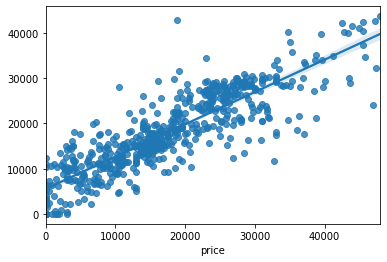

In [11]:
############ Training the model ##############

X = cars_dataset.drop("price",axis=1)
y = cars_dataset["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

regressor = RidgeCV(alphas=[0.0001,0.001,0.01,0.1,1,1e1,1e2,1e3,1e4,1e5,1e6], store_cv_values=True)
regressor.fit(X_train, y_train)
cv_mse = np.mean(regressor.cv_values_, axis=0)
#print([0.0001,0.001,0.01,0.1,1,1e1,1e2,1e3,1e4,1e5,1e6])
#print(cv_mse)

# Best alpha
print("Best alpha = " + str(regressor.alpha_))

y_pred = pd.Series(regressor.predict(X_test))

y_pred[y_pred<0]=0

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R_2 = {:.2f} %".format((r2_score(y_test, y_pred)*100)))
print("Variance score = {:.2f} %".format((regressor.score(X_test, y_test)*100)))

#print('10% of Mean Price:', cars_dataset['price'].mean() * 0.1)

sns.regplot(y_test,y_pred)
plt.show()

# The above scores and scatter plot between predicted vs actual ouptut show that the model has good accuracy